In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./ETC-M.csv', parse_dates=[0], index_col=[0])
df.drop('value', axis = 1, inplace = True)
df.head(3)

,open,high,low,close,volume
2017-09-25 22:05:00,11900.0,11900.0,11900.0,11900.0,0.0001
2017-09-25 22:06:00,11900.0,11900.0,11900.0,11900.0,0.0001
2017-09-25 22:07:00,11900.0,11900.0,11900.0,11900.0,0.0001


In [3]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
import indicators as idc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CDataset(Dataset):
    def __init__(self, df, seq_length):
        super(CDataset, self).__init__()
        self.s_len = seq_length
        df_T = idc.resample_T(df, '1T')
    ### x data
        df_T['RSI'] = idc.RSI(df_T,14).values / 100
        df_T['BB'], df_T['BP'] = idc.BB(df_T,20)
        df_T['MACD'], _ = idc.MACD(df_T)
        df_T['dis'] = idc.disparity(df_T, 20)
        df_T['volume'] = (df_T['volume'] - df_T['volume'].mean()) / df_T['volume'].std()

        df_T['EMA5'] = idc.EMA(df_T,5)
        df_T['EMA30'] = idc.EMA(df_T,30)
        df_T['EMA60'] = idc.EMA(df_T,60)
        df_T['EMA90'] = idc.EMA(df_T,90)
        
        df_c = df_T['close'].shift()
        for i in ['open','high','low','close']:
            df_T[i] = (df_T[i] - df_c) / df_c
            df_T[i] = df_T[i] / df_T[i].abs().max()
        
        print(df_T['BB'].max())
        df_T['BB'] = df_T['BB'] / df_T['BB'].max()
        for i in ['BP', 'MACD', 'dis']:
            print(df_T[i].min(), df_T[i].max())
            df_T[i] = df_T[i] - df_T[i].min()
            print(df_T[i].max())
            df_T[i] /= df_T[i].max()
                       
        self.x = torch.FloatTensor(df_T[60:-80].T.values).to(device)
        self.len = len(self.x[0])-self.s_len

    def __getitem__(self, index):
        self.x_data = self.x[:, index:index+self.s_len]
        self.x_data[-4:] -= self.x_data[-4:].min(1, keepdim=True)[0]
        self.x_data[-4:] /= self.x_data[-4:].max(1, keepdim=True)[0]
        self.x_data = torch.nan_to_num(self.x_data)
        return self.x_data
    
    def __len__(self):
        return self.len

pred = np.zeros(len(df))
dataset = CDataset(df, 64)
data_loader = DataLoader(dataset, batch_size=128, shuffle=False)
len(dataset)

0.4280650199268169
-0.5898003255280515 1.590171351399975
2.1799716769280266
-1835.7891845988452 2246.1288143263173
4081.9179989251625
78.7547991205714 115.54459079231742
36.789791671746016


2407449

In [5]:
import torch.nn as nn
import torch.optim as optim

class SCI_Block(nn.Module):
    def __init__(self, features, hidden, dropout=0.5):
        super(SCI_Block,self).__init__()
        self.dropout = dropout
        self.pad = nn.ReplicationPad1d((1,0))
        self.phi = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=4,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=4),
            nn.Tanh()
        )
        self.psi = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=5,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=3),
            nn.Tanh()
        )
        self.U   = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=5,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=3),
            nn.Tanh()
        )
        self.P   = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=5,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=3),
            nn.Tanh()
        )
    
    def forward(self, F):
        if F.size()[2] %2 == 1:
            F = self.pad(F)
        Fe = F[:, :,  ::2]
        Fo = F[:, :, 1::2]
        d = Fo.mul(torch.exp(self.phi(Fe)))
        c = Fe.mul(torch.exp(self.psi(Fo)))
        
        Fe = c + self.U(d)
        Fo = d - self.P(c)
        
        return Fo, Fe
    

class SCINet(nn.Module):
    def __init__(self, L, features, hidden):
        super(SCINet, self).__init__()
        self.num_layer = 2**L-1
        self.L = L
        self.layers = nn.ModuleList(
            [SCI_Block(features, hidden) for i in range(self.num_layer)])
        
    def forward(self, x):
        results = [x]
        for i in range(self.num_layer):
            seq = results.pop(0)
            Fo, Fe = self.layers[i](seq)
            results.append(Fo)
            results.append(Fe)
        
        interval = 2**(self.L-1)
        while True:
            res = []
            for i in range(interval):
                res.append(torch.cat((results[i], results[i+interval]),2))
            
            results = res
            if interval == 1:
                break
            else:
                interval = interval//2
        x = x + results[0]
        return x
    
class SCINet_stack(nn.Module):
    def __init__(self, stacks, layers, features, hidden=16):
        super(SCINet_stack, self).__init__()
        self.layers = nn.ModuleList(
            [SCINet(layers,features,hidden) for i in range(stacks)])
        self.fc1 = nn.Linear(64,16)
        self.fc2 = nn.Linear(16*features,64)
        self.fc3 = nn.Linear(64,16)
        self.fc4 = nn.Linear(16,1)
    
    def forward(self, x):
        for i in self.layers:
            x = i(x)
        x = self.fc1(x)
        x = self.fc2(x.flatten(1))
        x = self.fc3(x)
        x = self.fc4(x)
        return x


model = SCINet_stack(2,6,14, hidden=16).to(device)
path = "./SCINp.pt"
model.load_state_dict(torch.load(path))
model.to(device)
model.eval()

SCINet_stack(
  (layers): ModuleList(
    (0): SCINet(
      (layers): ModuleList(
        (0): SCI_Block(
          (pad): ReplicationPad1d((1, 0))
          (phi): Sequential(
            (0): ReplicationPad1d((5, 1))
            (1): Conv1d(14, 16, kernel_size=(4,), stride=(1,))
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
            (3): Dropout(p=0.5, inplace=False)
            (4): Conv1d(16, 14, kernel_size=(4,), stride=(1,))
            (5): Tanh()
          )
          (psi): Sequential(
            (0): ReplicationPad1d((5, 1))
            (1): Conv1d(14, 16, kernel_size=(5,), stride=(1,))
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
            (3): Dropout(p=0.5, inplace=False)
            (4): Conv1d(16, 14, kernel_size=(3,), stride=(1,))
            (5): Tanh()
          )
          (U): Sequential(
            (0): ReplicationPad1d((5, 1))
            (1): Conv1d(14, 16, kernel_size=(5,), stride=(1,))
            (2): LeakyReLU(negative

In [6]:
# results=[]
# for idx, data in enumerate(data_loader):
#     pred = model(data)
#     results = np.append(results, pred.tolist())

In [7]:
# import pickle
# with open("result.pkl", "wb") as fp:
#     pickle.dump(results, fp)

In [8]:
import pickle
with open("result.pkl", "rb") as fp:
    results = pickle.load(fp)

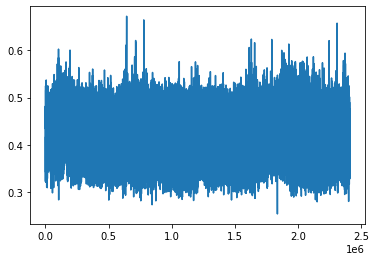

In [9]:
plt.plot(results)

In [43]:
from tqdm import tqdm
start = 60

bpl = []
spl = []
tradel = []
totall = []
for i in tqdm(range(46245,46255)):
    bp = i * 0.00001
    for j in range(7789,7795):
        sp = j * 0.00001

        buy=False
        now_price = 0
        total_price = 0
        trade = 0
        max_p = 0
        add = 0

        for v, i in enumerate(results):
            if i > bp and not buy:
                buy = True
                now_price = df['open'][start+v]
                trade += 1

                
            if buy == True:
                if i > max_p:
                    max_p = i
                if i < (max_p - sp):
                    buy = False
                    add += (df['open'][start+v]*0.998 - now_price) / now_price
                    trade += 1
                    max_p = 0
            
            # if i < sp and buy:
            #     buy=False
            #     if (df['open'][start+v]*0.9985 - now_price) > 0:
            #         add += 0.8
            #     else :
            #         add -= 1
            #     # add += (df['open'][start+v]*0.9985 - now_price) / now_price
            #     trade += 1
        
        bpl.append(bp)
        spl.append(sp)
        tradel.append(trade)
        totall.append(add)

100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


In [44]:
tmp = max(totall)
idx = totall.index(tmp)

print(idx)
print(bpl[idx], spl[idx], tradel[idx], totall[idx])

43
0.46252000000000004 0.07790000000000001 24044 82.38185036225131


In [37]:
buy = False
now_price = 0 
total_price = 0
trade = 0
start=60
bp = 0.463
sp = 0.078
max_p = 0

buy_t = []
sell_t = []
for v,i in enumerate(results):
    # buy
    if i>bp and not buy:
        buy = True
        now_price = df['open'][start+v]
        trade += 1
        buy_t.append(start+v)
    
#     # sell
#     if i<sp and buy:
#         buy = False
#         add = df['close'][start+v] - now_price
# #         print(add)
#         total_price += add
#         trade += 1
#         sell_t.append(start+v)

    if buy == True:
        if i > max_p:
            max_p = i
        if i < (max_p - sp):
            buy = False
            add = (df['open'][start+v]- now_price) 
            total_price += add
            trade += 1
            sell_t.append(start+v)
            max_p = 0
if buy:
    sell_t.append(0)

In [38]:
buy_np = np.array(buy_t)
sell_np = np.array(sell_t)
print(len(buy_np), len(sell_np))
print(trade)
print(total_price)
np.stack((buy_np, sell_np)).T

11880 11880
23760
2961886.9071056605


array([[     85,     210],
       [    337,     437],
       [    659,     811],
       ...,
       [2406605, 2406783],
       [2406878, 2406944],
       [2407218, 2407304]])

In [30]:
buy_np = np.array(buy_t)
sell_np = np.array(sell_t)
print(len(buy_np), len(sell_np))
print(trade)
print(total_price)
np.stack((buy_np, sell_np)).T

28298 28298
56596
3708845.971495756


array([[     61,     138],
       [    152,     177],
       [    186,     200],
       ...,
       [2407080, 2407117],
       [2407188, 2407203],
       [2407213, 2407285]])

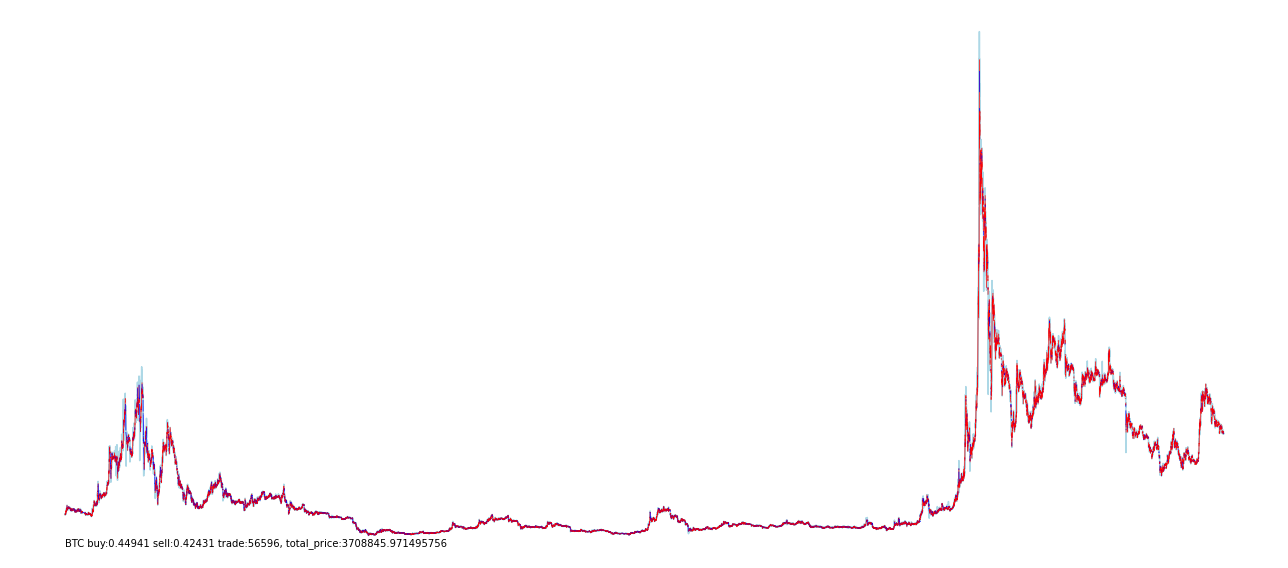

In [31]:
import matplotlib.pyplot as plt

start = 0
end = -1
df_c = df['close'].reset_index(drop=True)

plt.figure(figsize = (18,8))
plt.axis('off')
plt.plot(df_c[buy_np[start]:sell_np[end]], zorder=0, color='lightblue')
line_x = np.stack((buy_np[start:end], sell_np[start:end]), axis=1)
line_y = np.stack((df_c.iloc[buy_np[start:end]], df_c.iloc[sell_np[start:end]]), axis=1)
for i in range(len(buy_np[start:end])):
    if line_y[i][0] < line_y[i][1]:
        plt.plot(line_x[i], line_y[i], color='r', linewidth=0.7, label="Increase")
        pass
    else:
        plt.plot(line_x[i], line_y[i], color='b', linewidth=0.7, label="decrease")
plt.text(0,0.8, f'BTC buy:{bp} sell:{sp} trade:{trade}, total_price:{total_price}')
# plt.scatter(buy_np[:100], df_c.iloc[buy_np[:100]], marker='.',color='red', zorder=1)
# plt.scatter(sell_np[:100], df_c.iloc[sell_np[:100]], marker='.',color='blue', zorder=1)
plt.tight_layout()
plt.show()